**import** **libraries**

In [2]:
import os
import random
import numpy as np
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image,ImageEnhance
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

**connect** **to** **drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir='/content/drive/MyDrive/brain_tumor/Training'
test_dir='/content/drive/MyDrive/brain_tumor/Testing'

**create image path and labels for train and** **test**

In [5]:
train_paths=[]
train_labels=[]
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir,label)):
    train_paths.append(os.path.join(train_dir,label,image))
    train_labels.append(label)
test_paths=[]
test_labels=[]
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,image))
    test_labels.append(label)

**shuffle the train paths and train labels**

In [6]:

from sklearn.utils import shuffle
train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

In [7]:
os.listdir(train_dir)

['notumor', 'pituitary', 'meningioma', 'glioma']

**plotting any random 15 images**

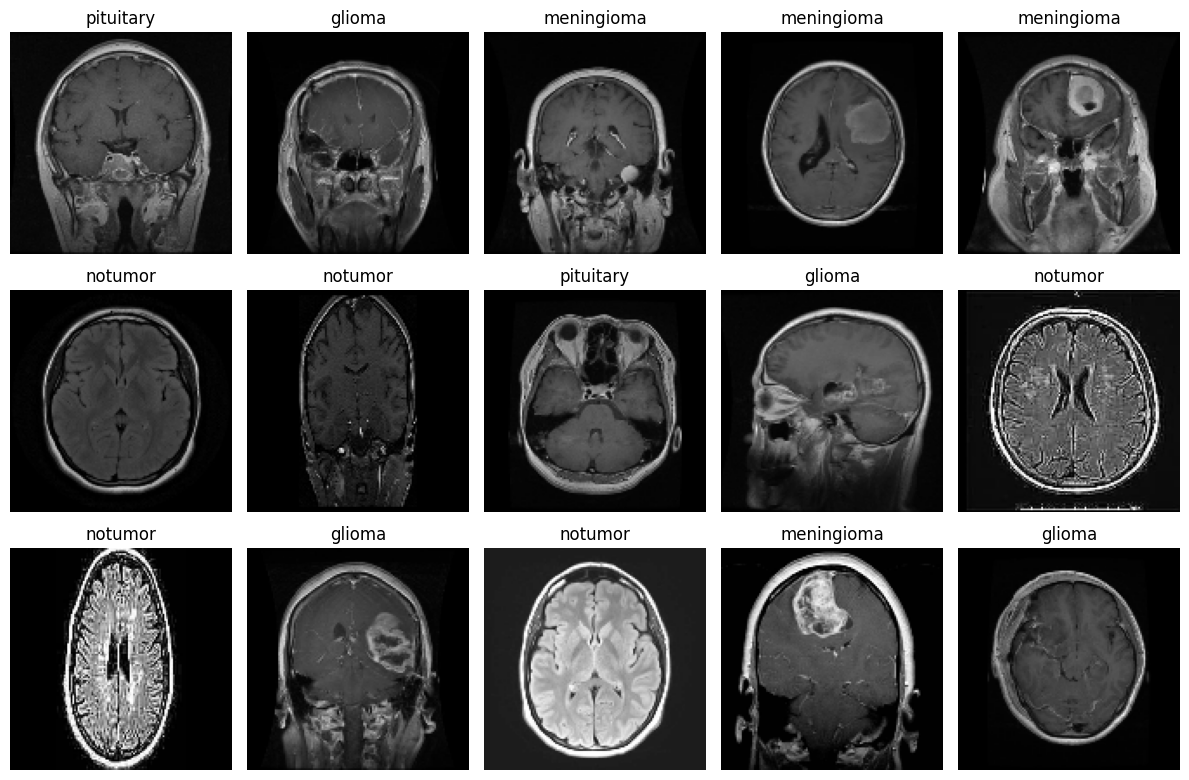

In [8]:
import matplotlib.pyplot as plt
import cv2

def show_images(img_paths, labels, rows=3, cols=5, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    for i in range(rows*cols):
        img = cv2.imread(img_paths[i])
        img = cv2.resize(img, (128, 128))

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()
show_images(train_paths[:15], train_labels[:15])

**oversampling**

In [9]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create a DataFrame from the existing train_paths and train_labels
df = pd.DataFrame({'train_dir': train_paths, 'label': train_labels})

# Convert labels to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df['label'])

# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['train_dir']], y_encoded)

# Convert back to labels
y_labels = le.inverse_transform(y_resampled)

# Final DataFrame with oversampled data
df_balanced = pd.DataFrame({'filename': X_resampled['train_dir'], 'label': y_labels})

**creating data pipeline for training and validation**

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% validation
)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 5104 validated image filenames belonging to 4 classes.
Found 1276 validated image filenames belonging to 4 classes.


**building a VGG16 model**

In [11]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

# freeze base model layers
for layer in base_model.layers:
  layer.trainable=False
for layer in base_model.layers[-3:]:
  layer.trainable=True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [12]:
# build model on top of VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

**compile the model**

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**add early stopping**

In [17]:
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

**train the model**

In [18]:
history=model.fit(train_generator,
                  validation_data=val_generator,
                  epochs=30,
                  callbacks=[early_stopping]
                  )

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3164s 20s/step - accuracy: 0.7435 - loss: 0.6766 - val_accuracy: 0.9350 - val_loss: 0.1979
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 238ms/step - accuracy: 0.9275 - loss: 0.2113 - val_accuracy: 0.9483 - val_loss: 0.1497
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.9584 - loss: 0.1145 - val_accuracy: 0.9569 - val_loss: 0.1200
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.9769 - loss: 0.0667 - val_accuracy: 0.9600 - val_loss: 0.1184
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.9810 - loss: 0.0589 - val_accuracy: 0.9687 - val_loss: 0.0860
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.9907 - loss: 0.0316 - val_accuracy: 0.9663 - val_loss: 0.1127
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.9946 - loss: 0.0179 - val_accuracy: 0.9459 - val_loss: 0.2020
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.9896 - loss: 0

**evaluate the model**

In [19]:
model.evaluate(val_generator)

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9692 - loss: 0.0864


[0.08602464944124222, 0.9686520099639893]

**get true labels to predict the probabilities**

In [20]:
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step


In [21]:
class_labels = list(val_generator.class_indices.keys())

**plot classification report and confusion matrix**

              precision    recall  f1-score   support

      glioma       0.96      0.97      0.97       287
  meningioma       0.93      0.95      0.94       291
     notumor       0.99      0.99      0.99       387
   pituitary       0.99      0.97      0.98       319

    accuracy                           0.97      1284
   macro avg       0.97      0.97      0.97      1284
weighted avg       0.97      0.97      0.97      1284



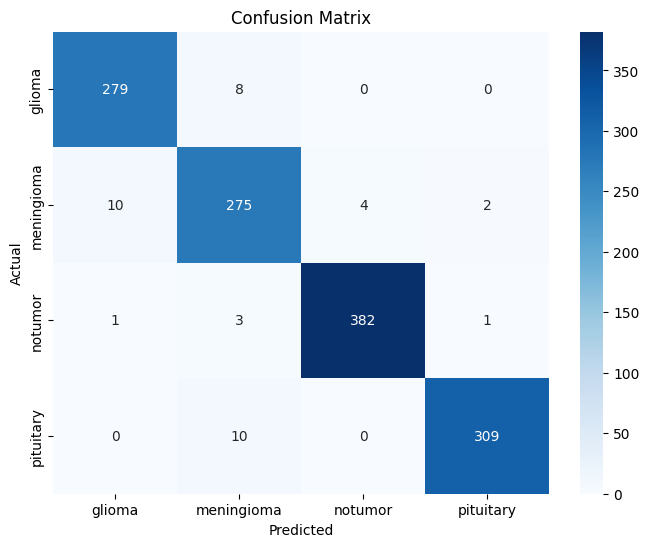

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**save the model**

In [22]:
model.save('model.h5')

In [23]:
# load the trained model
from tensorflow.keras.models import load_model
model=load_model('model.h5')

**test one image from test set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
confidence: 100.00%


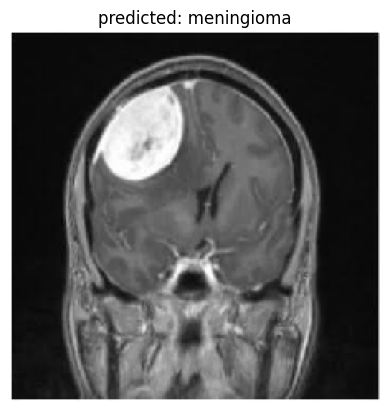

In [31]:
from tensorflow.keras.preprocessing import image

#define path manually
img_path='/content/drive/MyDrive/brain_tumor/Testing/meningioma/Te-me_0061.jpg'

# load image and resize it to match model input size
img=image.load_img(img_path,target_size=(224,224))

#convert the image to numpy array
img_array=image.img_to_array(img)

# preprocess image like in training
img_preprocessed=img_array / 255.0

#expand the dimensions
img_array_expanded=np.expand_dims(img_preprocessed,axis=0)


#predict the class
predictions=model.predict(img_array_expanded)
predicted_class_index=np.argmax(predictions)

#map index to class name
class_names=['glioma', 'meningioma', 'notumor', 'pituitary']
predicted_class_name=class_names[predicted_class_index]

#show the image and prediction
plt.imshow(img)
plt.title(f"predicted: {predicted_class_name}")
confidence = predictions[0][predicted_class_index]
print(f"confidence: {confidence*100:.2f}%")
plt.axis('off')
plt.show()

**model summary**

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,502 (80.64 MB)

 Trainable params: 11,143,428 (42.51 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

 Optimizer params: 2 (12.00 B)

**plot accuarcy and loss**

Text(0.5, 1.0, 'Accuracy')

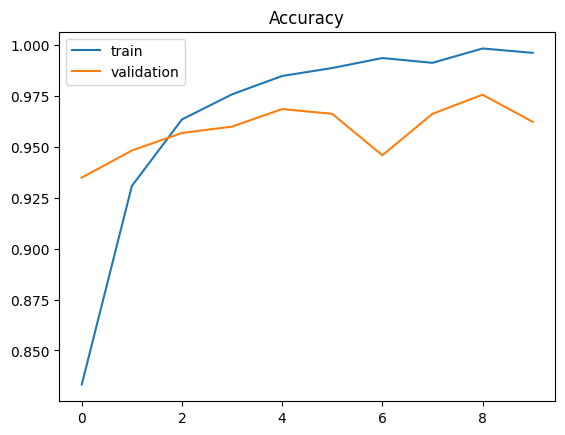

In [33]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

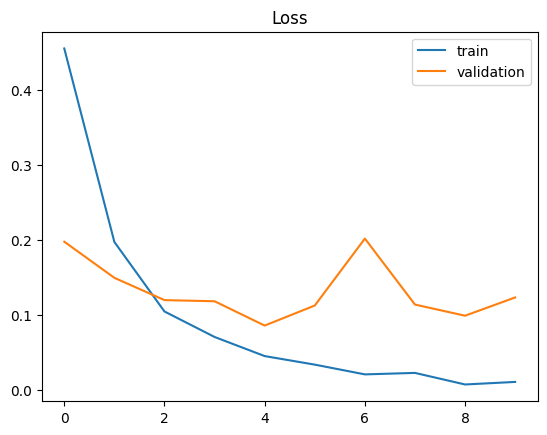

In [34]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss')